In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Initialize a Dask client
client = Client()

# Function to read CSV files using Dask
def read_csv_dask(file_path, dtypes):
    return dd.read_csv(file_path, dtype=dtypes, na_values='\\N')

# Define dtypes for each CSV file
lap_times_dtypes = {
    'raceId': 'int64',
    'driverId': 'int64',
    'lap': 'int64',
    'position': 'int64',
    'time': 'object',
    'milliseconds': 'int64'
}

races_dtypes = {
    'raceId': 'int64',
    'year': 'int64',
    'round': 'int64',
    'circuitId': 'int64',
    'name': 'object',
    'date': 'object',
    'time': 'object',
    'url': 'object',
    'fp1_date': 'object',
    'fp1_time': 'object',
    'fp2_date': 'object',
    'fp2_time': 'object',
    'fp3_date': 'object',
    'fp3_time': 'object',
    'quali_date': 'object',
    'quali_time': 'object',
    'sprint_date': 'object',
    'sprint_time': 'object'
}

results_dtypes = {
    'resultId': 'int64',
    'raceId': 'int64',
    'driverId': 'int64',
    'constructorId': 'int64',
    'number': 'float64',  # changed to float to handle NaNs
    'grid': 'int64',
    'position': 'float64',  # changed to float to handle NaNs
    'positionText': 'object',
    'positionOrder': 'int64',
    'points': 'float64',
    'laps': 'int64',
    'time': 'object',
    'milliseconds': 'float64',
    'fastestLap': 'float64',  # changed to float to handle NaNs
    'rank': 'float64',  # changed to float to handle NaNs
    'fastestLapTime': 'object',
    'fastestLapSpeed': 'float64',  # changed to float to handle NaNs
    'statusId': 'int64'
}

pit_stops_dtypes = {
    'raceId': 'int64',
    'driverId': 'int64',
    'stop': 'int64',
    'lap': 'int64',
    'time': 'object',
    'duration': 'object',
    'milliseconds': 'int64'
}

qualifying_dtypes = {
    'qualifyId': 'int64',
    'raceId': 'int64',
    'driverId': 'int64',
    'constructorId': 'int64',
    'number': 'int64',
    'position': 'float64',  # changed to float to handle NaNs
    'q1': 'object',
    'q2': 'object',
    'q3': 'object'
}

# Read the CSV files using Dask
lap_times = read_csv_dask('/content/drive/MyDrive/Colab Notebooks/lap_times.csv', lap_times_dtypes)
races = read_csv_dask('/content/drive/MyDrive/Colab Notebooks/races.csv', races_dtypes)
results = read_csv_dask('/content/drive/MyDrive/Colab Notebooks/results.csv', results_dtypes)
pit_stops = read_csv_dask('/content/drive/MyDrive/Colab Notebooks/pit_stops.csv', pit_stops_dtypes)
qualifying = read_csv_dask('/content/drive/MyDrive/Colab Notebooks/qualifying.csv', qualifying_dtypes)

# Select necessary columns from races dataframe
races = races[['raceId', 'year', 'name']]

# Filter data for the selected seasons (2014-2023)
races = races[(races['year'] >= 2014) & (races['year'] <= 2023)]

# Get raceId from remaining races inb races to filter other datasets
races_ids = races['raceId'].compute()

# Filter datasets
lap_times = lap_times[lap_times['raceId'].isin(races_ids)]
results = results[results['raceId'].isin(races_ids)]
pit_stops = pit_stops[pit_stops['raceId'].isin(races_ids)]
qualifying = qualifying[qualifying['raceId'].isin(races_ids)]


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42623
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43223'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40813'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:36343', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36343
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34518
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44295', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44295
INFO:distributed.core:Sta

In [2]:
# Print the number of unique raceIds remaining in each dataset
print("Number of unique races in lap_times:", lap_times['raceId'].nunique().compute())
print("Number of unique races in results:", results['raceId'].nunique().compute())
print("Number of unique races in pit_stops:", pit_stops['raceId'].nunique().compute())
print("Number of unique races in qualifying:", qualifying['raceId'].nunique().compute())
print("Number of unique races in races:", races['raceId'].nunique().compute())




Number of unique races in lap_times: 194
Number of unique races in results: 194
Number of unique races in pit_stops: 193
Number of unique races in qualifying: 194
Number of unique races in races: 204


In [3]:
# Compute unique raceIds in each dataset
lap_times_ids = lap_times['raceId'].unique().compute()
results_ids = results['raceId'].unique().compute()
pit_stops_ids = pit_stops['raceId'].unique().compute()
qualifying_ids = qualifying['raceId'].unique().compute()

# Find the intersection of all raceIds
common_race_ids = set(lap_times_ids) & set(results_ids) & set(pit_stops_ids) & set(qualifying_ids)

# Filter each dataset to only include common raceIds
lap_times = lap_times[lap_times['raceId'].isin(common_race_ids)]
results = results[results['raceId'].isin(common_race_ids)]
pit_stops = pit_stops[pit_stops['raceId'].isin(common_race_ids)]
qualifying = qualifying[qualifying['raceId'].isin(common_race_ids)]
races = races[races['raceId'].isin(common_race_ids)]

In [4]:
# Print the number of unique raceIds remaining in each dataset
print("Number of unique races in lap_times:", lap_times['raceId'].nunique().compute())
print("Number of unique races in results:", results['raceId'].nunique().compute())
print("Number of unique races in pit_stops:", pit_stops['raceId'].nunique().compute())
print("Number of unique races in qualifying:", qualifying['raceId'].nunique().compute())
print("Number of unique races in races:", races['raceId'].nunique().compute())

Number of unique races in lap_times: 193
Number of unique races in results: 193
Number of unique races in pit_stops: 193
Number of unique races in qualifying: 193
Number of unique races in races: 193


In [5]:
# Function to filter data for a specific race and driver
def filter_race_driver_data(lap_times, race_id, driver_id):
    df = lap_times[(lap_times['raceId'] == race_id) & (lap_times['driverId'] == driver_id)].compute()
    df = df.reset_index(drop=True)
    df.index = df.index + 1
    return df

In [6]:
# Print a readable list of all the raceIds along with the name of the race
races_info = races[['raceId', 'name']].compute()
print("List of Race IDs and Race Names:")
for index, row in races_info.iterrows():
    print(f"Race ID: {row['raceId']}, Race Name: {row['name']}")

List of Race IDs and Race Names:
Race ID: 900, Race Name: Australian Grand Prix
Race ID: 901, Race Name: Malaysian Grand Prix
Race ID: 902, Race Name: Bahrain Grand Prix
Race ID: 903, Race Name: Chinese Grand Prix
Race ID: 904, Race Name: Spanish Grand Prix
Race ID: 905, Race Name: Monaco Grand Prix
Race ID: 906, Race Name: Canadian Grand Prix
Race ID: 907, Race Name: Austrian Grand Prix
Race ID: 908, Race Name: British Grand Prix
Race ID: 909, Race Name: German Grand Prix
Race ID: 910, Race Name: Hungarian Grand Prix
Race ID: 911, Race Name: Belgian Grand Prix
Race ID: 912, Race Name: Italian Grand Prix
Race ID: 913, Race Name: Singapore Grand Prix
Race ID: 914, Race Name: Japanese Grand Prix
Race ID: 915, Race Name: Russian Grand Prix
Race ID: 916, Race Name: United States Grand Prix
Race ID: 917, Race Name: Brazilian Grand Prix
Race ID: 918, Race Name: Abu Dhabi Grand Prix
Race ID: 931, Race Name: Monaco Grand Prix
Race ID: 932, Race Name: Canadian Grand Prix
Race ID: 929, Race Name

In [7]:
# Function to print a list of all driverIds for a particular race
def print_drivers_for_race(results, race_id):
    drivers_for_race = results[results['raceId'] == race_id]['driverId'].unique().compute()
    print(f"List of Driver IDs for Race ID {race_id}:")
    for driver_id in drivers_for_race:
        print(driver_id)

# Example usage
selected_race_id = int(input("Enter the raceId of the race you'd like to choose: "))
print_drivers_for_race(results, selected_race_id)

Enter the raceId of the race you'd like to choose: 1044
List of Driver IDs for Race ID 1044:
1
815
20
844
832
830
848
846
840
817
839
826
842
822
8
847
825
154
849
841


In [8]:
# Function to adjust lap times for pit stops across all data
def adjust_lap_times_for_pit_stops(lap_times, pit_stops):
    lap_times_df = lap_times.compute()
    pit_stops_df = pit_stops.compute()

    # Merge lap times with pit stops to adjust laps with pit stops
    merged_df = lap_times_df.merge(pit_stops_df[['raceId', 'driverId', 'lap', 'milliseconds']],
                                   on=['raceId', 'driverId', 'lap'],
                                   how='left',
                                   suffixes=('', '_pit_stop'))

    # Adjust lap times for laps with pit stops
    merged_df['adjusted_milliseconds'] = merged_df['milliseconds'] - merged_df['milliseconds_pit_stop'].fillna(0)
    merged_df = merged_df.drop(columns=['milliseconds', 'milliseconds_pit_stop']).rename(columns={'adjusted_milliseconds': 'milliseconds'})

    return merged_df

In [9]:
# Adjust lap times for pit stops
adjusted_lap_times = adjust_lap_times_for_pit_stops(lap_times, pit_stops)

In [10]:
# Function to create lag features and rolling mean
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['milliseconds'].shift(i)
    df['rolling_mean'] = df['milliseconds'].rolling(window=lag).mean()
    df = df.dropna().reset_index(drop=True)
    return df

# Apply feature engineering to adjusted lap times
adjusted_lap_times = create_lag_features(adjusted_lap_times)

In [11]:
def prepare_data_for_lstm(df, n_steps=5):
    X, y = [], []
    numeric_cols = ['milliseconds', 'rolling_mean'] + [f'lag_{i}' for i in range(1, n_steps + 1)]
    for i in range(len(df) - n_steps):
        X.append(df.iloc[i:i + n_steps][numeric_cols].values)
        y.append(df.iloc[i + n_steps]['milliseconds'])
    return np.array(X), np.array(y)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of milliseconds
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['milliseconds'], bins=50, kde=True)
plt.title('Distribution of Milliseconds')
plt.show()

# Distribution of lag features
plt.figure(figsize=(10, 6))
for i in range(1, 6):
    sns.histplot(filtered_data[f'lag_{i}'], bins=50, kde=True, label=f'lag_{i}')
plt.title('Distribution of Lag Features')
plt.legend()
plt.show()

In [12]:
X, y = prepare_data_for_lstm(adjusted_lap_times)

In [13]:
# Check the shapes of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Print a few samples from X and y
print("Sample data from X:")
print(X[:3])  # Print the first 3 sequences

print("Sample data from y:")
print(y[:3])  # Print the corresponding first 3 target values

Shape of X: (210775, 5, 7)
Shape of y: (210775,)
Sample data from X:
[[[ 94977.   95761.2  95438.   94939.   95765.   97687.  102038. ]
  [ 95417.   95307.2  94977.   95438.   94939.   95765.   97687. ]
  [ 94550.   95064.2  95417.   94977.   95438.   94939.   95765. ]
  [ 94217.   94919.8  94550.   95417.   94977.   95438.   94939. ]
  [ 94364.   94705.   94217.   94550.   95417.   94977.   95438. ]]

 [[ 95417.   95307.2  94977.   95438.   94939.   95765.   97687. ]
  [ 94550.   95064.2  95417.   94977.   95438.   94939.   95765. ]
  [ 94217.   94919.8  94550.   95417.   94977.   95438.   94939. ]
  [ 94364.   94705.   94217.   94550.   95417.   94977.   95438. ]
  [ 95185.   94746.6  94364.   94217.   94550.   95417.   94977. ]]

 [[ 94550.   95064.2  95417.   94977.   95438.   94939.   95765. ]
  [ 94217.   94919.8  94550.   95417.   94977.   95438.   94939. ]
  [ 94364.   94705.   94217.   94550.   95417.   94977.   95438. ]
  [ 95185.   94746.6  94364.   94217.   94550.   95417. 

In [14]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

In [15]:
# Scale the target variable y
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Check the shapes and a few samples after scaling
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

print("Sample data from X:")
print(X[:3])  # Print the first 3 sequences

print("Sample data from y:")
print(y[:3])  # Print the corresponding first 3 target values

Shape of X: (210775, 5, 7)
Shape of y: (210775,)
Sample data from X:
[[[0.01104314 0.06416032 0.01618835 0.01062113 0.01983926 0.04128741
   0.08984018]
  [0.015953   0.04774062 0.01104415 0.01618936 0.0106221  0.01984022
   0.04128828]
  [0.00627834 0.03895211 0.01595401 0.01104516 0.01619034 0.01062306
   0.01984109]
  [0.00256246 0.03372963 0.00627934 0.01595503 0.01104614 0.01619129
   0.01062392]
  [0.0042028  0.02596102 0.00256347 0.00628036 0.015956   0.01104709
   0.01619216]]

 [[0.015953   0.04774062 0.01104415 0.01618936 0.0106221  0.01984022
   0.04128828]
  [0.00627834 0.03895211 0.01595401 0.01104516 0.01619034 0.01062306
   0.01984109]
  [0.00256246 0.03372963 0.00627934 0.01595503 0.01104614 0.01619129
   0.01062392]
  [0.0042028  0.02596102 0.00256347 0.00628036 0.015956   0.01104709
   0.01619216]
  [0.01336417 0.02746556 0.00420381 0.00256448 0.00628134 0.01595696
   0.01104796]]

 [[0.00627834 0.03895211 0.01595401 0.01104516 0.01619034 0.01062306
   0.01984109]
  [

In [16]:
print("CUDA available:", "yes" if torch.cuda.is_available() else "no")

CUDA available: yes


Epoch 1/50, Train Loss: 0.6553, Val Loss: 0.7678
Epoch 2/50, Train Loss: 0.5515, Val Loss: 0.7167
Epoch 3/50, Train Loss: 0.5412, Val Loss: 0.7086
Epoch 4/50, Train Loss: 0.5345, Val Loss: 0.6807
Epoch 5/50, Train Loss: 0.5294, Val Loss: 0.6707
Epoch 6/50, Train Loss: 0.5230, Val Loss: 0.6672
Epoch 7/50, Train Loss: 0.5187, Val Loss: 0.6999
Epoch 8/50, Train Loss: 0.5180, Val Loss: 0.7197
Epoch 9/50, Train Loss: 0.5148, Val Loss: 0.6951
Epoch 10/50, Train Loss: 0.5105, Val Loss: 0.6955
Epoch 11/50, Train Loss: 0.5121, Val Loss: 0.6623
Epoch 12/50, Train Loss: 0.5088, Val Loss: 0.6925
Epoch 13/50, Train Loss: 0.5042, Val Loss: 0.7001
Epoch 14/50, Train Loss: 0.5013, Val Loss: 0.6801
Epoch 15/50, Train Loss: 0.4949, Val Loss: 0.6852
Epoch 16/50, Train Loss: 0.4879, Val Loss: 0.6753
Epoch 17/50, Train Loss: 0.4865, Val Loss: 0.6814
Epoch 18/50, Train Loss: 0.4774, Val Loss: 0.6907
Epoch 19/50, Train Loss: 0.4718, Val Loss: 0.6629
Epoch 20/50, Train Loss: 0.4677, Val Loss: 0.6672
Epoch 21/

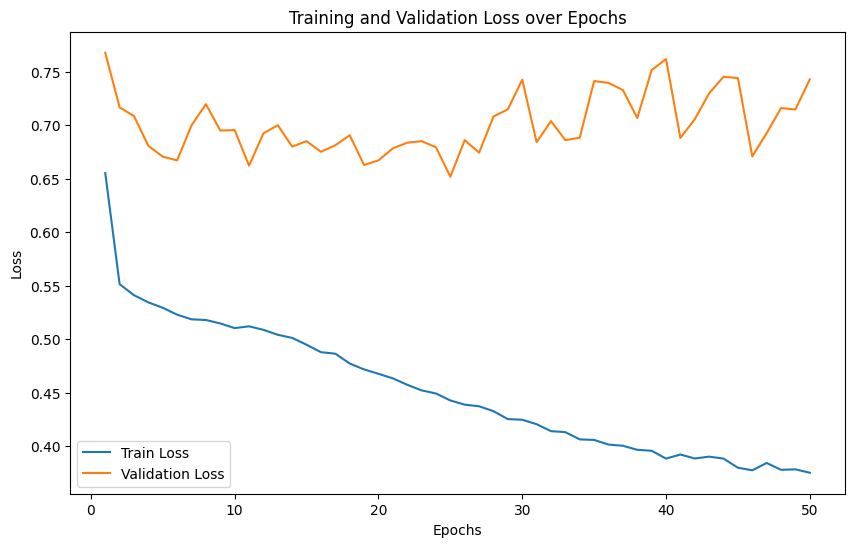

In [17]:
'''



# Convert data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)
y = y.view(-1, 1)

# Split data into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 50
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
batch_size = 75

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Lists to track loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss.item():.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()
'''


In [18]:
# Example: Filter data for a specific race and driver
selected_race_id = 1069  # Replace with the actual raceId
selected_driver_id = 20  # Replace with the actual driverId

# Get the filtered data
filtered_data = filter_race_driver_data(lap_times, selected_race_id, selected_driver_id)

# Sort data by lap number
filtered_data = filtered_data.sort_values(by='lap')

# Display the filtered and sorted data
print(filtered_data.head())

   raceId  driverId  lap  position      time  milliseconds
1    1069        20    1        15  1:52.788        112788
2    1069        20    2        15  1:46.841        106841
3    1069        20    3        15  1:46.358        106358
4    1069        20    4        14  1:44.512        104512
5    1069        20    5        14  1:44.105        104105


In [19]:
# Create lag features for previous lap times
def create_lag_features(df, lag=5):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['milliseconds'].shift(i)
    return df.dropna()

# Apply feature engineering
filtered_data = create_lag_features(filtered_data)
# Drop the 'time' column from the filtered data
filtered_data = filtered_data.drop(columns=['time'])

# Display the data with lag features
print(filtered_data.head())

    raceId  driverId  lap  position  milliseconds     lag_1     lag_2  \
6     1069        20    6        14        104481  104105.0  104512.0   
7     1069        20    7        14        104703  104481.0  104105.0   
8     1069        20    8        14        104456  104703.0  104481.0   
9     1069        20    9        12        103263  104456.0  104703.0   
10    1069        20   10        11        104342  103263.0  104456.0   

       lag_3     lag_4     lag_5  
6   106358.0  106841.0  112788.0  
7   104512.0  106358.0  106841.0  
8   104105.0  104512.0  106358.0  
9   104481.0  104105.0  104512.0  
10  104703.0  104481.0  104105.0  


In [ ]:
'''
# Select a specific race event
selected_race = 'Australian Grand Prix'
selected_race_id = races[races['name'] == selected_race]['raceId'].compute().values[0]

# Select a specific driver
selected_driver_id = 1

# Filter data for the selected race and driver
lap_times_filtered = lap_times[(lap_times['raceId'] == selected_race_id) & (lap_times['driverId'] == selected_driver_id)]
results_filtered = results[(results['raceId'] == selected_race_id) & (results['driverId'] == selected_driver_id)]
pit_stops_filtered = pit_stops[(pit_stops['raceId'] == selected_race_id) & (pit_stops['driverId'] == selected_driver_id)]
qualifying_filtered = qualifying[(qualifying['raceId'] == selected_race_id) & (qualifying['driverId'] == selected_driver_id)]

def convert_time_to_seconds(time_str):
    try:
        minutes, seconds_ms = time_str.split(':')
        seconds, milliseconds = seconds_ms.split('.')
        total_seconds = int(minutes) * 60 + int(seconds) + int(milliseconds) * 0.1
        return total_seconds
    except ValueError:
        return pd.NaT

# Clean and preprocess the data
lap_times_filtered['lapTime'] = lap_times_filtered['time'].astype(str).apply(convert_time_to_seconds)
results_filtered['fastestLapTime'] = results_filtered['fastestLapTime'].astype(str).apply(convert_time_to_seconds)
pit_stops_filtered['duration'] = pit_stops_filtered['milliseconds'] / 1000

# Join the filtered datasets
final_data = dd.merge(lap_times_filtered, results_filtered[['grid', 'fastestLapTime']], on=['raceId', 'driverId'], how='left')
final_data = dd.merge(final_data, pit_stops_filtered[['lap', 'duration']], on=['raceId', 'driverId', 'lap'], how='left')
final_data = dd.merge(final_data, qualifying_filtered[['q1', 'q2', 'q3']], on=['raceId', 'driverId'], how='left')

# Compute the final dataset
final_data = final_data.compute()

# Print the final dataset
print(final_data)
'''